# Loan Approval Prediction 
In this notebook we will build a binary classification model to predict whether a loan application will be approved or not.





#  Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # to combine SMOTE safely


# Load Dataset


In [3]:
df = pd.read_csv("loan_approval_dataset.csv")  # or your path




# Data Exploration

In [4]:
print(df.shape)
df.head()

(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
print("First 5 rows:\n", df.head(), "\n")
print("Dataset Info:\n")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

print("\nSummary Statistics:\n", df.describe(include="all"))
print("\nUnique Values in Each Column:\n", df.nunique())

First 5 rows:
    loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_asset_value  \
0          

In [6]:
print(df.columns)

# Clean up column names (strip spaces + lowercase for consistency)
df.columns = df.columns.str.strip().str.lower()

print(df.columns)  # check cleaned names



Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')
Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')


In [7]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


# Data Visualization

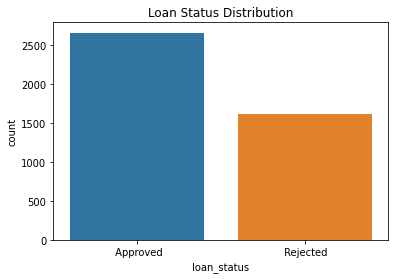

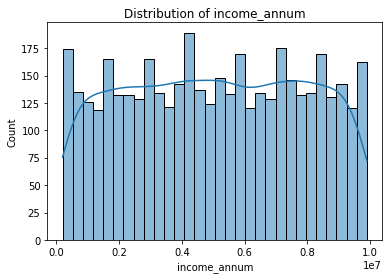

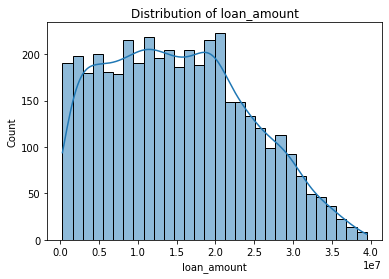

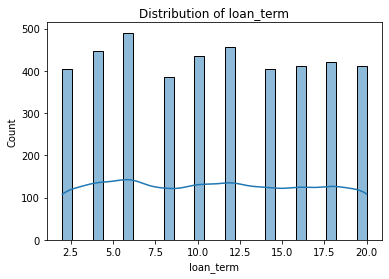

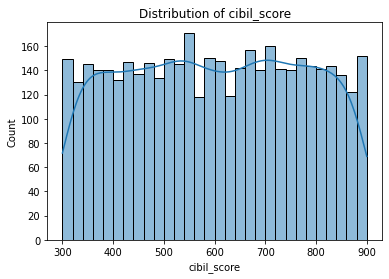

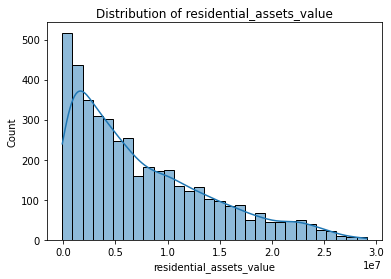

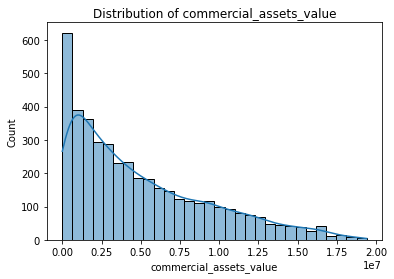

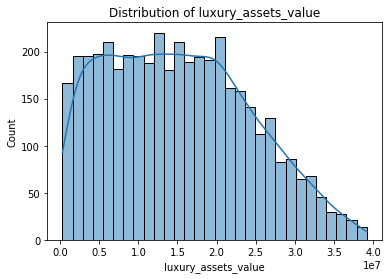

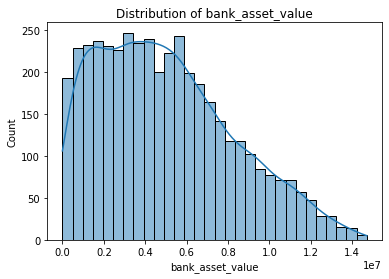

In [8]:
# --- Target Distribution ---
sns.countplot(x="loan_status", data=df)
plt.title("Loan Status Distribution")
plt.show()

# Numerical features distribution
num_cols = ["income_annum", "loan_amount", "loan_term", "cibil_score",
            "residential_assets_value", "commercial_assets_value",
            "luxury_assets_value", "bank_asset_value"]

for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()


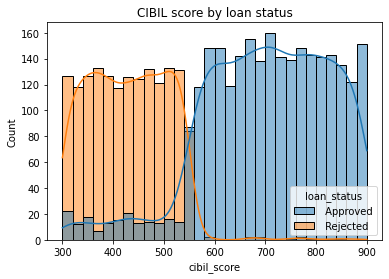

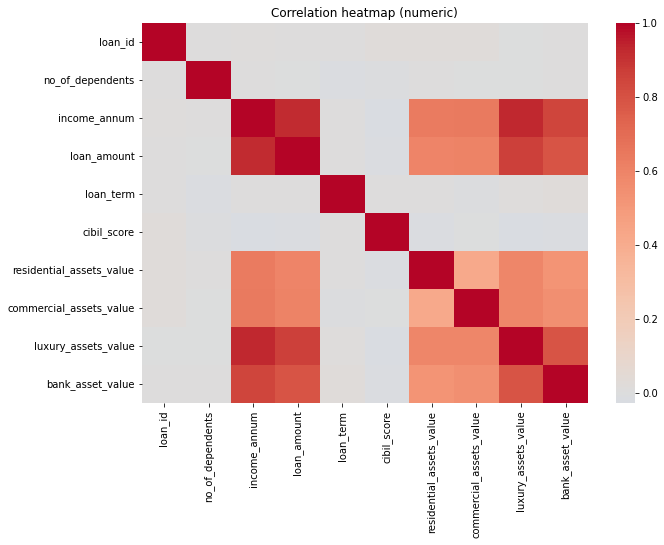

In [9]:
# CIBIL vs status
sns.histplot(data=df, x="cibil_score", hue="loan_status", kde=True, bins=30)
plt.title("CIBIL score by loan status")
plt.show()

# Correlation (numeric only)
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric)")
plt.show()


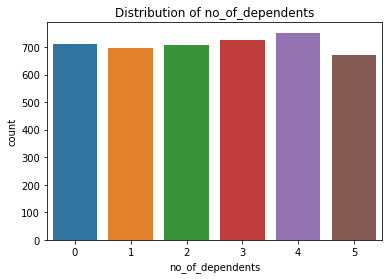

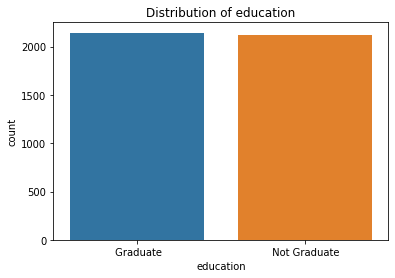

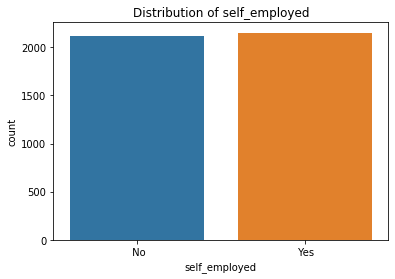

In [10]:
# Categorical feature distributions
cat_cols = ["no_of_dependents", "education", "self_employed"]
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df)
        plt.title(f"Distribution of {col}")
        plt.show()




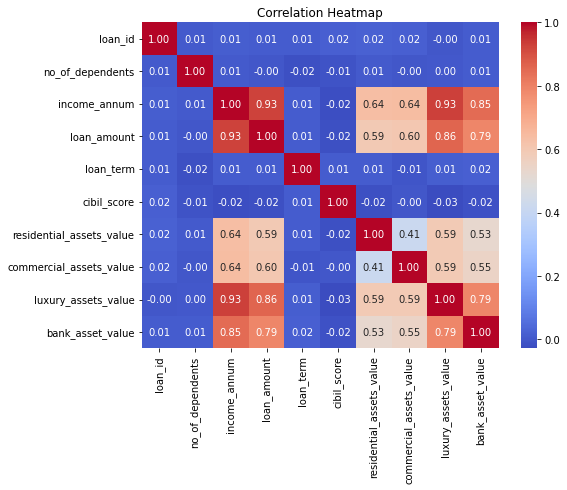

In [11]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Data Preprocessing
 Encode categorical features

In [12]:
# Identify features/target
target = "loan_status"
id_cols = ["loan_id"]  # drop from features

# Categorical columns (string/object)
cat_cols = [c for c in df.columns if df[c].dtype == 'O' and c != target]
# With your dataset, these should be: ['education', 'self_employed']

# Numeric columns (everything else except id/target)
num_cols = [c for c in df.columns if c not in cat_cols + id_cols + [target]]

print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)


Categorical cols: ['education', 'self_employed']
Numeric cols: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']


In [13]:
# Split BEFORE any resampling to avoid leakage
X = df.drop(columns=id_cols + [target], errors='ignore')
y = df[target].astype(str)  # keep labels as strings for reports

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train class balance:\n", y_train.value_counts())


Train size: (3415, 11)  Test size: (854, 11)
Train class balance:
  Approved    2125
 Rejected    1290
Name: loan_status, dtype: int64


# Model Training

Handle class imbalance with SMOTE(Bonus)

In [14]:
# =========================
# Pipelines (with SMOTE)
# =========================
# One-hot for categoricals; pass-through numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# 1) Logistic Regression pipeline
log_pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])
# 2) Decision Tree pipeline
tree_pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", DecisionTreeClassifier(random_state=42))
])


In [15]:
log_pipe.fit(X_train, y_train)
tree_pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model Evaluation


=== Logistic Regression ===
              precision    recall  f1-score   support

    Approved     0.8290    0.8399    0.8344       531
    Rejected     0.7310    0.7152    0.7230       323

    accuracy                         0.7927       854
   macro avg     0.7800    0.7775    0.7787       854
weighted avg     0.7919    0.7927    0.7923       854



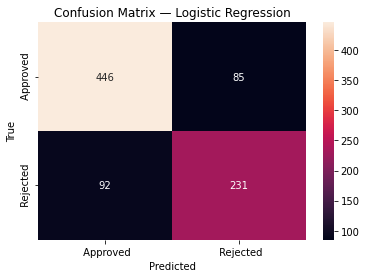


=== Decision Tree ===
              precision    recall  f1-score   support

    Approved     0.9741    0.9906    0.9823       531
    Rejected     0.9841    0.9567    0.9702       323

    accuracy                         0.9778       854
   macro avg     0.9791    0.9736    0.9762       854
weighted avg     0.9779    0.9778    0.9777       854



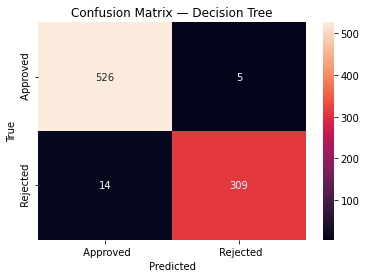

In [16]:
def evaluate_model(name, pipe, X_test, y_test):
    print(f"\n=== {name} ===")
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=sorted(y_test.unique()),
                yticklabels=sorted(y_test.unique()))
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # Precision-Recall curve (Approved vs Rejected — pick positive class explicitly)
    # Make sure we know which label is positive:
    # Let's treat 'Approved' as positive class.
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        # Get probability for positive class 'Approved'
        classes = pipe.named_steps['clf'].classes_
        if 'Approved' in classes:
            pos_idx = list(classes).index('Approved')
            y_scores = pipe.predict_proba(X_test)[:, pos_idx]
            y_true = (y_test == 'Approved').astype(int)
            ap = average_precision_score(y_true, y_scores)
            precision, recall, _ = precision_recall_curve(y_true, y_scores)

            plt.figure(figsize=(6,4))
            plt.plot(recall, precision)
            plt.xlabel("Recall"); plt.ylabel("Precision")
            plt.title(f"Precision–Recall Curve — {name} (AP={ap:.3f})")
            plt.show()

evaluate_model("Logistic Regression", log_pipe, X_test, y_test)
evaluate_model("Decision Tree", tree_pipe, X_test, y_test)


# Hyperparameter Tuning


Best Logistic Regression params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

=== LogReg (Tuned) ===
              precision    recall  f1-score   support

    Approved     0.8290    0.8399    0.8344       531
    Rejected     0.7310    0.7152    0.7230       323

    accuracy                         0.7927       854
   macro avg     0.7800    0.7775    0.7787       854
weighted avg     0.7919    0.7927    0.7923       854



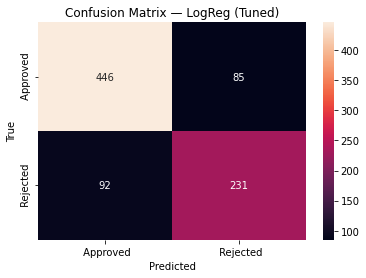


Best Decision Tree params: {'clf__ccp_alpha': 0.0, 'clf__max_depth': None, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2}

=== Decision Tree (Tuned) ===
              precision    recall  f1-score   support

    Approved     0.9759    0.9925    0.9841       531
    Rejected     0.9873    0.9598    0.9733       323

    accuracy                         0.9801       854
   macro avg     0.9816    0.9761    0.9787       854
weighted avg     0.9802    0.9801    0.9800       854



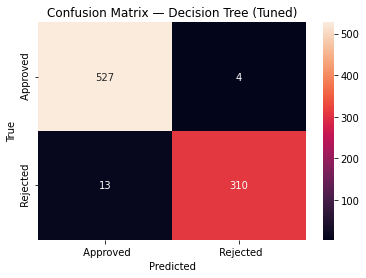

In [17]:
log_param_grid = {
    "clf__penalty": ["l2"],
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "clf__solver": ["liblinear", "lbfgs"]
}

log_grid = GridSearchCV(
    estimator=log_pipe,
    param_grid=log_param_grid,
    scoring="f1_macro",  # focus on F1 across both classes
    cv=5,
    n_jobs=-1,
    verbose=0
)
log_grid.fit(X_train, y_train)
print("\nBest Logistic Regression params:", log_grid.best_params_)
evaluate_model("LogReg (Tuned)", log_grid.best_estimator_, X_test, y_test)

tree_param_grid = {
    "clf__max_depth": [None, 4, 6, 8, 12],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__ccp_alpha": [0.0, 0.001, 0.01]
}

tree_grid = GridSearchCV(
    estimator=tree_pipe,
    param_grid=tree_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=0
)
tree_grid.fit(X_train, y_train)
print("\nBest Decision Tree params:", tree_grid.best_params_)
evaluate_model("Decision Tree (Tuned)", tree_grid.best_estimator_, X_test, y_test)



Top 10 features (Decision Tree):
 cibil_score                 0.878305
loan_term                   0.064111
loan_amount                 0.025701
income_annum                0.015112
commercial_assets_value     0.006776
luxury_assets_value         0.006273
self_employed_ Yes          0.001660
no_of_dependents            0.000975
residential_assets_value    0.000765
bank_asset_value            0.000323
dtype: float64


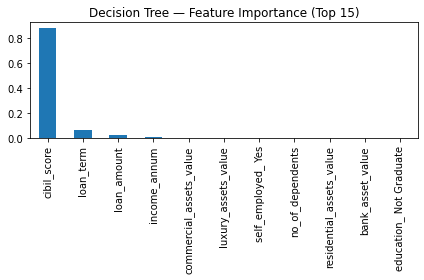

In [18]:
def show_tree_feature_importance(best_tree_pipe, X_train):
    # Build final feature names after preprocessing
    ohe = best_tree_pipe.named_steps["prep"].named_transformers_["cat"]
    # onehot feature names
    cat_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
    feature_names = cat_names + num_cols

    clf = best_tree_pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        imps = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
        print("\nTop 10 features (Decision Tree):\n", imps.head(10))
        imps.head(15).plot(kind="bar")
        plt.title("Decision Tree — Feature Importance (Top 15)")
        plt.tight_layout()
        plt.show()

show_tree_feature_importance(tree_grid.best_estimator_, X_train)

In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    tree_grid.best_estimator_, X, y,
    cv=cv, scoring="f1_macro", n_jobs=-1
)

print("Cross-val F1 scores:", scores)
print("Mean F1:", scores.mean(), "±", scores.std())


Cross-val F1 scores: [0.9750117  0.97374581 0.98500702 0.97630532 0.98251763]
Mean F1: 0.9785174962802596 ± 0.0044287306763829155


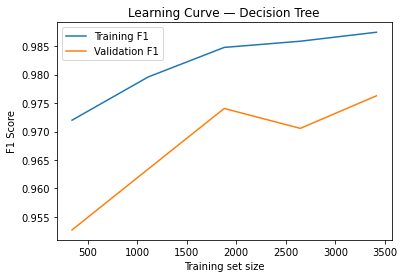

In [20]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    tree_grid.best_estimator_, X, y,
    cv=5, scoring="f1_macro", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, test_mean, label="Validation F1")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Learning Curve — Decision Tree")
plt.show()


##  Conclusion  

We built and evaluated two models — **Logistic Regression** and **Decision Tree** — for loan approval prediction.  

- **Logistic Regression (tuned)** achieved an overall accuracy of **79.3%**, with stronger performance on predicting “Approved” cases (precision 0.83, recall 0.84) but weaker on “Rejected” cases (precision 0.73, recall 0.71). This suggests it struggles with the minority class despite balancing.  

- **Decision Tree (tuned)** significantly outperformed Logistic Regression, reaching an accuracy of **98.0%**. It showed very high precision and recall for both “Approved” (0.98+) and “Rejected” (0.97+), meaning it was highly reliable across both classes.  

- **Feature importance analysis** revealed that **CIBIL score** was by far the most influential factor in loan approval, followed by **loan term, loan amount, and income**. Asset values and employment status contributed only marginally.  

###  Key Insights
1. **Decision Trees** are far more effective than Logistic Regression for this dataset, likely because they capture non-linear patterns in credit behaviour.  
2. **CIBIL score** is the dominant factor in loan approval, confirming domain intuition that credit history is critical in lending decisions.  
3. Logistic Regression, while interpretable, may be too simple for complex financial data.  

###  Final Takeaway  
For this task, **Decision Tree is the recommended model** due to its strong predictive performance and ability to highlight key decision factors. Logistic Regression serves as a good baseline but is not competitive on this dataset.  
